In [1]:
!pip install torch
!pip install torchvision
!pip install gym
!pip install gym[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp38-cp38-win_amd64.whl size=488216 sha256=ac9dd866f8e65a5cfed681ce2d8b6b7511a499c5798fa2ad513c48fde70b665b
  Stored in directory: c:\users\chris\appdata\local\pip\cache\wheels\8b\95\16\1dc99ff9a3f316ff245fdb5c9086cd13c35dad630809909075
Successfully built box2d-py


In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
import copy, random
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

*Environment*: CarRacing-v0

*Action*: a combination of steering, stepping on gas, and stepping on brake (Can I mimmic a trail-braking?)

*State*: the screen of the game

*Reward*: using the default for now

*Q*(s, a)*: will be approximated by a DNN


# Environment

In [7]:
env = gym.make('CarRacing-v0')

In [8]:
env.reset()
while True:
    #env.render()
    state, reward, done, info = env.step([0,0,0])
    #print(reward, done, info)
    if done:
        break
env.close()

Track generation: 1411..1768 -> 357-tiles track


In [17]:
# reduce the action space with a wrapper
class BasicWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        self.__actions__ = [[-0.7, 0.1, 0.],
                             [0.7, 0.1, 0.],
                             [0., 0.7, 0.],
                             [0., 0., 0.7],
                             [0., 0., 0.]]
        
        self.action_space = Box(0, 4, shape=(1,), dtype=np.int8)
        
    def step(self, action):
        next_state, reward, done, info = self.env.step(self.__actions__[action])
        # modify ...
        return next_state, reward, done, info

# Skip some frames
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

#make the track into gray scale
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        h, w = self.observation_space.shape[:2]
        obs_shape = (h-16, w)
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
    
    def permute_orientation(self, observation):
        observation = np.transpose(observation, (2,0,1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation
    
    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        observation = observation.squeeze(0)
        return observation[:-16]

In [18]:
def env_make():
    env = gym.make('CarRacing-v0')
    env = SkipFrame(env, 2)
    env = BasicWrapper(env)
    env = GrayScaleObservation(env)
    env = FrameStack(env, num_stack=2)
    return env

In [19]:
env = env_make()

In [24]:
env.observation_space.shape

(2, 80, 96)

In [21]:
env.reset()
for _ in range(60):
    env.step(4)

Track generation: 1151..1450 -> 299-tiles track


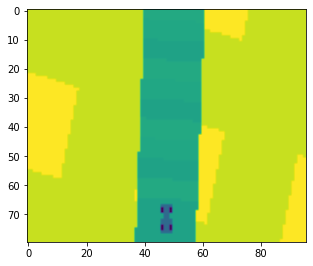

False {}


In [23]:
state, reward, done, info = env.step(4)
plt.figure(figsize=(5,5))
plt.imshow(state[0])
plt.show()
print(done, info)

# Agent

In [29]:
class LewisNet(nn.Module):
    """
    cnn structure
    input -> (conv2d + relu) X 3 -> flatten -> (dense + relu) X 2 -> output
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim
        
        if h != 80:
            raise ValueError(f"Expecting input height: 96, got: {h}")
        if w != 96:
            raise ValueError(f"Expecting input height: 96, got: {w}") 
            
        # Create Q
        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
        
        # Create Q_target
        self.target = copy.deepcopy(self.online)
        # Freeze Q_target
        for p in self.target.parameters():
            p.requires_grad = False
            
    def forward(self, inp, model):
        if model == "online":
            return self.online(inp)
        elif model == "target":
            return self.target(inp)

In [30]:
class lewis:
    def __init__(self, state_dim, action_dim, save_dir):
        """
        An agent to drive the car
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        
        self.use_cuda = torch.cuda.is_available()
        self.net = LewisNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")
            
        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0
        
        self.save_every = 5e5 # no. of experiences between saving
        
        # cache and recall
        self.memory = deque(maxlen=100000)
        self.batch_size = 32
        
        # learn
        self.gamma = 0.9
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()
        
        self.burnin = 1e4
        self.learn_every = 3
        self.sync_every = 1e4
        
    
    def act(self, state):
        """
        Given a state choose an epsilon-greedy action
        
        Inputs:
        state(LazyFrame): a single observation, dimension = state_dim
        Outputs:
        action_idx(int): an integer representing the action in the action space
        """
        # Explore
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
            
        # Exploit
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model='online')
            action_idx = torch.argmax(action_values, axis=1).item()
            
        # Decrease exploration rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
        # increment step
        self.curr_step += 1
        return action_idx
    
    def cache(self, state, next_state, action, reward, done):
        """
        Add the experience to memory
        Inputs:
        state (LazyFrame)
        next_state (LazyFrame)
        action (int)
        reward (float)
        done (bool)
        
        """
        state = state.__array__()
        next_state = next_state.__array__()
        
        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])
            
        self.memory.append((state, next_state, action, reward, done,))
            
    def recall(self):
        """Sample experiences from memory"""
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()
    
    def learn(self):
        """Update the Q function with a batch of experience"""
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()
            
        if self.curr_step % self.save_every == 0:
            self.save()
            
        if self.curr_step < self.burnin:
            return None, None
        
        if self.curr_step % self.learn_every != 0:
            return None, None
        
        state, next_state, action, reward, done = self.recall()
        
        td_est = self.td_estimate(state, action)
        
        td_tgt = self.td_target(reward, next_state, done)
        
        loss = self.update_Q_online(td_est, td_tgt)
        
        return (td_est.mean().item(), loss)
    
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]
        return current_Q
    
    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model='target')[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma*next_Q).float()
    
    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())
        
    def save(self):
        save_path = (self.save_dir / f"lewis_net_{int(self.curr_step//self.save_every)}.chkpt")
        torch.save(dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), save_path,)
        print(f"LewisNet saved to {save_path} at step {self.curr_step}")

# Logging

In [27]:
import time, datetime

class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# Play

In [31]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

lulu = lewis(state_dim=(2, 80, 96), action_dim=5, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 100
env = env_make()
for ep in range(episodes):
    state = env.reset()
    
    while True:
        action = lulu.act(state)
        
        next_state, reward, done, info = env.step(action)
        lulu.cache(state, next_state, action, reward, done)
        q, loss = lulu.learn()
        logger.log_step(reward, loss, q)
        state = next_state
        
        if done:
            break
    
    logger.log_episode()
    
    if ep%20 ==0:
        logger.record(episode=ep, epsilon=lulu.exploration_rate, step=lulu.curr_step)

Exception ignored in: <function Viewer.__del__ at 0x000002977A80EB80>
Traceback (most recent call last):
  File "C:\Users\Chris\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\Chris\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\Chris\anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 328, in close
    super(Win32Window, self).close()
  File "C:\Users\Chris\anaconda3\lib\site-packages\pyglet\window\__init__.py", line 857, in close
    app.windows.remove(self)
  File "C:\Users\Chris\anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000002970680C130; to 'Win32Window' at 0x0000029706781C40>


Using CUDA: False

Track generation: 1179..1478 -> 299-tiles track


Exception ignored in: <function Viewer.__del__ at 0x000002977A80EB80>
Traceback (most recent call last):
  File "C:\Users\Chris\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\Chris\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\Chris\anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 328, in close
    super(Win32Window, self).close()
  File "C:\Users\Chris\anaconda3\lib\site-packages\pyglet\window\__init__.py", line 857, in close
    app.windows.remove(self)
  File "C:\Users\Chris\anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000297071CF450; to 'Win32Window' at 0x000002970721F3A0>


Episode 0 - Step 500 - Epsilon 0.9998750077965335 - Mean Reward -29.53 - Mean Length 500.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.433 - Time 2022-02-02T20:32:13
Track generation: 1109..1392 -> 283-tiles track
Track generation: 1264..1595 -> 331-tiles track
Track generation: 992..1250 -> 258-tiles track
Track generation: 1023..1285 -> 262-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1152..1444 -> 292-tiles track
Track generation: 1117..1405 -> 288-tiles track
Track generation: 1186..1493 -> 307-tiles track
Track generation: 989..1241 -> 252-tiles track
Track generation: 1044..1309 -> 265-tiles track
Track generation: 1301..1629 -> 328-tiles track
Track generation: 999..1253 -> 254-tiles track
Track generation: 1158..1455 -> 297-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1203..1508 -> 305-tiles track
Track generation: 1083..1358 -> 275-tiles track

<Figure size 432x288 with 0 Axes>

In [32]:
env.close()